<a href="https://colab.research.google.com/github/evinracher/3008410-intelligent-systems/blob/main/week1/exercise1/Generative_vs_Discriminative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas

In [ ]:
pip install seaborn

# Discriminative vs Generative

Consideraciones

- Modelos Generativos pueden manejar datos faltantes de forma más natural.
  
- Modelos Discriminativos suelen tener mejor rendimiento para clasificar no para entender. El modelo no se preocupa por cómo es un email de spam en sí mismo, solo por qué palabras lo diferencian de uno que no es spam.

- Los modelos generativos pueden ser más fáciles de interpretar en términos de cómo se generan los datos de cada clase. Naive Bayes podría (en teoría) generar un nuevo email de "spam" muestreando palabras según P(palabra | spam). La Regresión Logística no podría, solo dice, dada una combinación de palabras, si es más probable que sea spam o no.
  

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer # Sigue sin ser necesario aquí
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt # Para visualizar la matriz de confusión
import seaborn as sns      # Para visualizar la matriz de confusión

nombre_archivo_datos = 'data_1000.csv' # --- Cargar los Datos ---
try:
    data = pd.read_csv(nombre_archivo_datos)
except FileNotFoundError:
    print(f"Error: Asegúrate de que el archivo '{nombre_archivo_datos}' esté en el mismo directorio que el script.")
    exit()

print("--- Datos Cargados ---")
print(f"Total de ejemplos: {len(data)}")
print(data.head())
print("\n")

# --- Preparación de los Datos ---
# Las características (X) son las columnas de palabras
# Obtenemos la lista de features dinámicamente del CSV (excluyendo 'email_id' y 'etiqueta')
features = [col for col in data.columns if col not in ['email_id', 'etiqueta']]

X = data[features]
y = data['etiqueta']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
print(f"Distribución de clases en y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribución de clases en y_test:\n{y_test.value_counts(normalize=True)}")
print("\n")


--- Datos Cargados ---
Total de ejemplos: 1000
   email_id  palabra_confirmar  palabra_dinero  palabra_factura  \
0         1                  1               0                0   
1         2                  0               1                0   
2         3                  0               0                0   
3         4                  0               0                0   
4         5                  0               0                0   

   palabra_gratis  palabra_informe  palabra_oferta  palabra_premio  \
0               1                0               0               1   
1               1                0               1               0   
2               0                0               1               0   
3               0                1               1               0   
4               0                1               0               0   

   palabra_proyecto  palabra_reunion  palabra_urgente etiqueta  
0                 0                0                0     spam  


1. Regresión Logística (Discriminativo):
   - Modela directamente P(clase | email) usando la función logística: 1 / (1 + exp(-z)), donde z = w*x + b.
   - Aprende los pesos 'w' (coeficientes) que mejor separan las clases.
   - No intenta modelar cómo se ven los emails de cada clase por separado, solo cómo distinguirlos.
   - Generalmente robusto y a menudo funciona muy bien en la práctica, especialmente si el supuesto de independencia de Naive Bayes no se cumple.
   - Suele tener mejor rendimiento predictivo si el objetivo es solo la clasificación.


--- Modelo Discriminativo: Regresión Logística ---
Exactitud (Accuracy) de Regresión Logística en el conjunto de prueba: 0.9600
Reporte de Clasificación de Regresión Logística:
              precision    recall  f1-score   support

     no spam       0.96      0.97      0.97       150
        spam       0.96      0.94      0.95       100

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



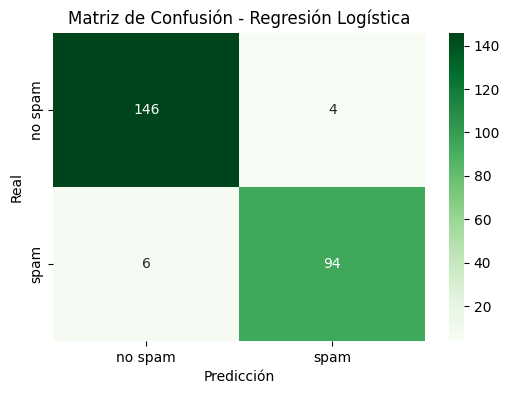


Coeficientes (pesos) aprendidos por Regresión Logística (P(Y|X)):
(Coeficientes mostrados para la clase 'spam' como positiva)
Coeficiente para palabra_confirmar: -0.5498
Coeficiente para palabra_dinero: 3.0068
Coeficiente para palabra_factura: -0.3178
Coeficiente para palabra_gratis: 3.0074
Coeficiente para palabra_informe: -2.3460
Coeficiente para palabra_oferta: 2.0939
Coeficiente para palabra_premio: 2.4326
Coeficiente para palabra_proyecto: -1.5865
Coeficiente para palabra_reunion: -1.6163
Coeficiente para palabra_urgente: 1.1445

Interpretación de los coeficientes:
Un coeficiente positivo grande para una palabra significa que la presencia de esa palabra incrementa la probabilidad (log-odds) de que el email sea 'spam'.




In [12]:

# --- Parte 1: Modelo Discriminativo (Regresión Logística) ---
print("--- Modelo Discriminativo: Regresión Logística ---")

log_reg_model = LogisticRegression(solver='liblinear', random_state=64, C=1.0) # C es el inverso de la regularización
log_reg_model.fit(X_train, y_train)

y_pred_lr = log_reg_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

print(f"Exactitud (Accuracy) de Regresión Logística en el conjunto de prueba: {accuracy_lr:.4f}")
print("Reporte de Clasificación de Regresión Logística:")
print(classification_report(y_test, y_pred_lr, zero_division=0))

# Matriz de confusión para Regresión Logística
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=log_reg_model.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=log_reg_model.classes_, yticklabels=log_reg_model.classes_)
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

print("\nCoeficientes (pesos) aprendidos por Regresión Logística (P(Y|X)):")
# log_reg_model.coef_ tiene forma (1, n_features) para clasificación binaria
# log_reg_model.classes_ nos dice el orden, ej. ['no spam', 'spam']. Si 'spam' es la clase 1:
clase_positiva_idx = np.where(log_reg_model.classes_ == 'spam')[0][0] # Asumiendo 'spam' es la clase de interés
if clase_positiva_idx == 1: # Si 'spam' es la segunda clase, los coeficientes son para ella
    coefs = log_reg_model.coef_[0]
else: # Si 'spam' es la primera clase, tomamos el negativo de los coeficientes (ya que LR modela P(clase_1|X))
    coefs = -log_reg_model.coef_[0]

intercept = log_reg_model.intercept_[0]
if clase_positiva_idx == 0 : intercept = -intercept # Ajustar intercepto si 'spam' no es la clase '1'

print(f"(Coeficientes mostrados para la clase 'spam' como positiva)")
for feature_name, coef in zip(features, coefs):
    print(f"Coeficiente para {feature_name}: {coef:.4f}")
# print(f"Intercepto (para clase 'spam'): {intercept:.4f}")


print("\nInterpretación de los coeficientes:")
print("Un coeficiente positivo grande para una palabra significa que la presencia de esa palabra incrementa la probabilidad (log-odds) de que el email sea 'spam'.")
print("\n")



2. Naive Bayes (Generativo):
   - Modela P(palabra | clase) y P(clase).
   - Usa el Teorema de Bayes para calcular P(clase | email) = P(email | clase) * P(clase) / P(email).
   - P(email | clase) se asume como el producto de P(palabra_i | clase) (supuesto de independencia 'naive').
   - Podríamos (conceptualmente) 'generar' emails de cada clase.
   - Puede ser bueno con pocos datos, sensible a características irrelevantes si no hay buen suavizado.
   - Al modelar P(X|Y), puede ser útil si se quieren generar nuevos datos o entender la distribución de cada clase.
     

--- Modelo Generativo: Naive Bayes Multinomial ---
Exactitud (Accuracy) de Naive Bayes en el conjunto de prueba: 0.9560
Reporte de Clasificación de Naive Bayes:
              precision    recall  f1-score   support

     no spam       0.96      0.97      0.96       150
        spam       0.95      0.94      0.94       100

    accuracy                           0.96       250
   macro avg       0.95      0.95      0.95       250
weighted avg       0.96      0.96      0.96       250



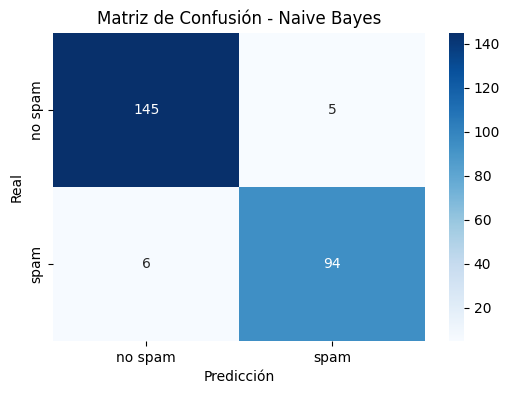


Probabilidades a priori de las clases (aprendidas por Naive Bayes P(Y)):
P(no spam) = 0.5987
P(spam) = 0.4013

(Log) Probabilidades condicionales P(X_i | Y) (para algunas palabras):
--- palabra_confirmar ---
  Log P(palabra_confirmar presente | no spam) ~= -2.0244
  Log P(palabra_confirmar presente | spam) ~= -2.7928
--- palabra_dinero ---
  Log P(palabra_dinero presente | no spam) ~= -5.1230
  Log P(palabra_dinero presente | spam) ~= -1.8585
--- palabra_factura ---
  Log P(palabra_factura presente | no spam) ~= -2.1785
  Log P(palabra_factura presente | spam) ~= -2.9500

Para 'generar' un email de spam (conceptual):
Muestrearías palabras basándote en las P(palabra presente | 'spam') aprendidas.




In [13]:
# --- Parte 2: Modelo Generativo (Naive Bayes Multinomial) ---
print("--- Modelo Generativo: Naive Bayes Multinomial ---")

nb_model = MultinomialNB() # alpha=1.0 por defecto para suavizado Laplace
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"Exactitud (Accuracy) de Naive Bayes en el conjunto de prueba: {accuracy_nb:.4f}")
print("Reporte de Clasificación de Naive Bayes:")
print(classification_report(y_test, y_pred_nb, zero_division=0))

# Matriz de confusión para Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=nb_model.classes_)
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title('Matriz de Confusión - Naive Bayes')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


print("\nProbabilidades a priori de las clases (aprendidas por Naive Bayes P(Y)):")
class_priors_nb = np.exp(nb_model.class_log_prior_)
for i, class_name in enumerate(nb_model.classes_):
    print(f"P({class_name}) = {class_priors_nb[i]:.4f}")

print("\n(Log) Probabilidades condicionales P(X_i | Y) (para algunas palabras):")
# Mostramos para las primeras 3 características
for k, feature_name in enumerate(features[:3]):
    print(f"--- {feature_name} ---")
    for i, class_name in enumerate(nb_model.classes_):
        log_prob_feature_given_class = nb_model.feature_log_prob_[i, k]
        # La probabilidad de que la característica sea 1 (o el valor que tenga) dada la clase.
        # Es más complejo interpretar esto directamente como P(feature=1|clase) sin mirar la implementación interna
        # de cómo MultinomialNB maneja las características. Pero sí representa la contribución de esa feature a esa clase.
        print(f"  Log P({feature_name} presente | {class_name}) ~= {log_prob_feature_given_class:.4f}")


print("\nPara 'generar' un email de spam (conceptual):")
print("Muestrearías palabras basándote en las P(palabra presente | 'spam') aprendidas.")
print("\n")



### Preguntas del ejercicio 1

--- Comparación y Discusión ---

Preguntas:

- Que pasa si se cambia el random state y la particion del dataset, continua siendo mejor el modelo discriminativo?

R: Sí, sigue siendo mejor la regresión logística

- ¿Qué modelo da más 'insights' sobre las características de CADA clase individualmente?
  
R: Naive Bayes, a través de P(palabra|clase), ya que nos da las probabilidades condicionales.
  
- ¿Qué modelo se enfoca más directamente en la tarea de SEPARACIÓN?

R: Regresión Logística, porque es un modelo discriminativo. Se enfoca en encontrar la frontera que mejor separa las dos clases a predecir.
  
- Si tuvieras que generar un nuevo email que parezca 'spam', ¿qué modelo sería más útil y por qué?

R: Naive Bayes, porque modela la distribución de las características dentro de cada clase P(X|Y). Además, es un modelo generativo, que busca entender como es la distribución de los datos para cada clase.

- ¿Qué modelo crees que podría ser más sensible si las palabras clave fueran altamente correlacionadas (ej. 'gratis' y 'premio' casi siempre aparecen juntas)?

R: Naive Bayes, porque su supuesto de independencia se violaría fuertemente. La Regresión Logística podría manejarlo mejor.
